# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
3542,0,29.0,22500.0,1,0
4972,1,25.0,29000.0,1,0
3441,1,23.0,13500.0,1,0
2509,0,25.0,52600.0,1,0
2344,1,22.0,34300.0,1,0
1708,1,36.0,50100.0,0,0
2241,0,36.0,22800.0,2,0
1917,1,44.0,48500.0,1,1
3471,0,42.0,46000.0,0,1
4462,0,29.0,44800.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:
df['age']= df['age'].astype(int)

In [8]:
# comprueba que la conversión se haya realizado con éxito

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [10]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?

In [11]:
data_miss = df.isna().sum()
print(f'En el DataFrame de Insurance se encontro que hay: \n{data_miss}\n')

En el DataFrame de Insurance se encontro que hay: 
gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64



Con este análisis se pudo comprobar que el DataFrame con el que estamos trabajando no tiene datos nulos. 

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

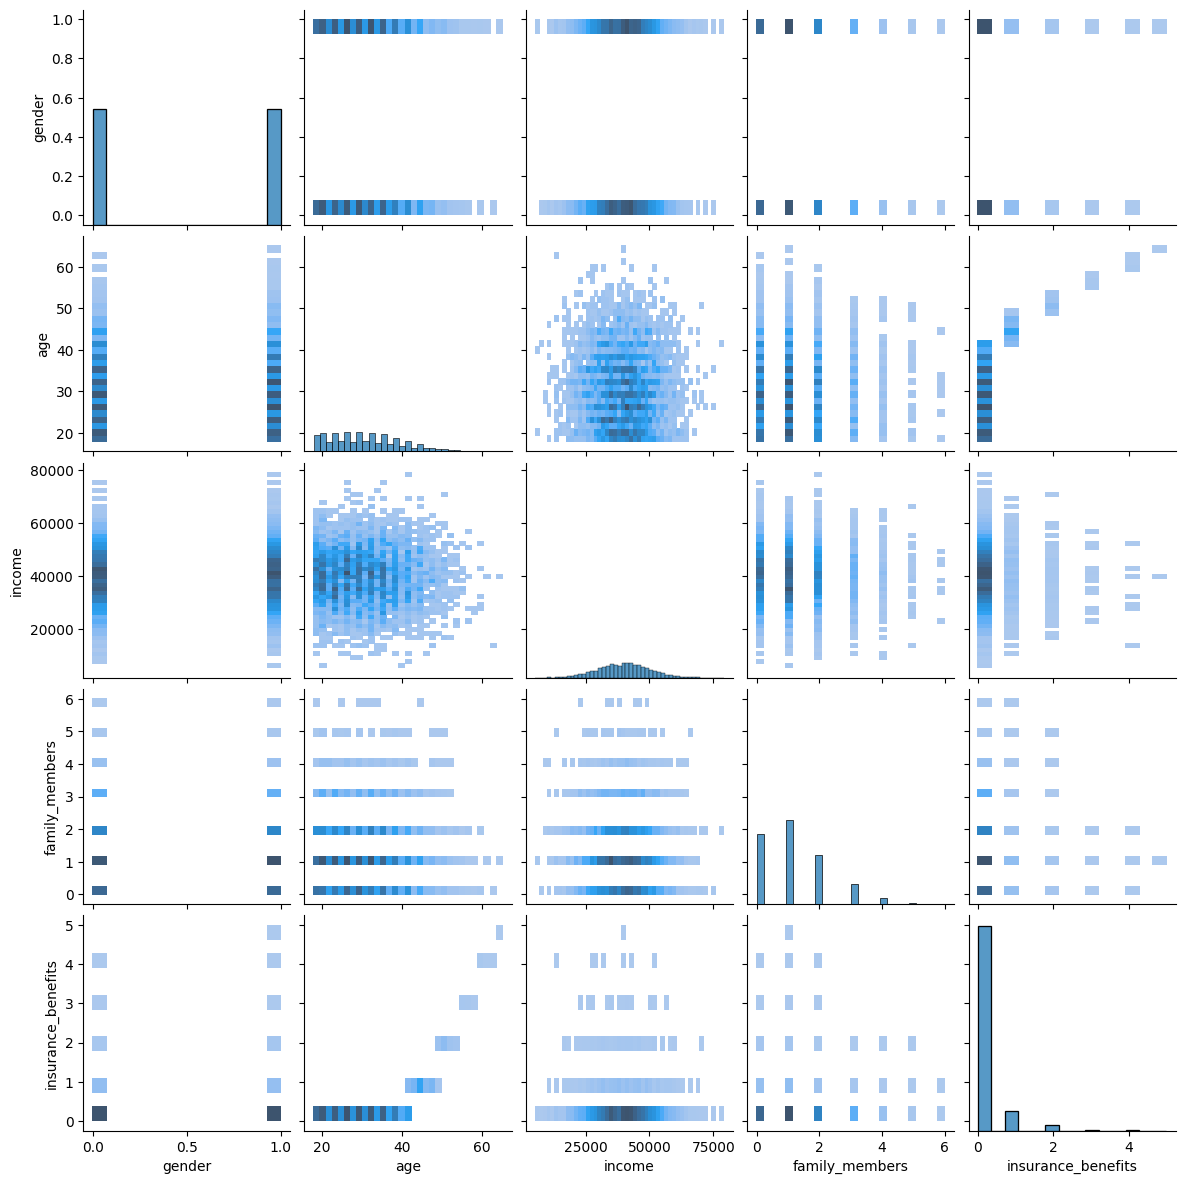

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [14]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    
    :param n: número de objetos para los que se buscan los vecinos más cercanos    
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors= k, metric = metric)
    nbrs.fit(df[feature_names]) # <tu código aquí> 
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [16]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
201,0.0,0.338462,0.406329,0.000000,0
4675,0.0,0.400000,0.592405,0.166667,0
2924,1.0,0.507692,0.482278,0.166667,0
4651,0.0,0.430769,0.421519,0.333333,0
4493,0.0,0.692308,0.878481,0.166667,1


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [17]:
# índice de referencía 
n = 1 #ejemplo, el primer vecino 
k = 5 # número de vecinos a estudiar 

# Combinación 1: Datos sin escalar, distancia Euclidiana
print("Datos sin escalar, distancia Euclidiana")
print(get_knn(df, n, k, metric = 'euclidean'))

Datos sin escalar, distancia Euclidiana
      gender  age   income  family_members  insurance_benefits   distance
1          0   46  38000.0               1                   1   0.000000
3920       0   40  38000.0               0                   0   6.082763
4948       1   37  38000.0               1                   0   9.055385
2528       1   36  38000.0               0                   0  10.099505
3593       0   33  38000.0               0                   0  13.038405


In [18]:
n = 1 #ejemplo, el primer vecino 
k = 5 # número de vecinos a estudia
#Combinación 2: Datos sin escalar, distancia Manhattan.
print("Datos sin escalar, distancia Manhattan.")
print(get_knn(df, n, k, metric ='manhattan'))

Datos sin escalar, distancia Manhattan.
      gender  age   income  family_members  insurance_benefits  distance
1          0   46  38000.0               1                   1       0.0
3920       0   40  38000.0               0                   0       7.0
4948       1   37  38000.0               1                   0      10.0
2528       1   36  38000.0               0                   0      12.0
3593       0   33  38000.0               0                   0      14.0


In [19]:
n = 1 #ejemplo, el primer vecino 
k = 5 # número de vecinos a estudia
#Combinación 3: Datos escalados, distanica Euclidiana
print("Datos escalados, distancia Euclidiana")
print(get_knn(df_scaled, n, k, metric="euclidean")) 

Datos escalados, distancia Euclidiana
      gender       age    income  family_members  insurance_benefits  distance
1        0.0  0.707692  0.481013        0.166667                   1  0.000000
4162     0.0  0.707692  0.477215        0.166667                   1  0.003797
1863     0.0  0.707692  0.492405        0.166667                   1  0.011392
4986     0.0  0.723077  0.491139        0.166667                   1  0.018418
4477     0.0  0.692308  0.459494        0.166667                   1  0.026453


In [20]:
n = 1 #ejemplo, el primer vecino 
k = 5 # número de vecinos a estudia
#Combinación 4: Datos escalados, distanica Manhattan
print("Datos escalados, distancia Manhattan")
print(get_knn(df_scaled, n, k, metric="manhattan")) 

Datos escalados, distancia Manhattan
      gender       age    income  family_members  insurance_benefits  distance
1        0.0  0.707692  0.481013        0.166667                   1  0.000000
4162     0.0  0.707692  0.477215        0.166667                   1  0.003797
1863     0.0  0.707692  0.492405        0.166667                   1  0.011392
4986     0.0  0.723077  0.491139        0.166667                   1  0.025511
2434     0.0  0.676923  0.482278        0.166667                   1  0.032035


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Al no estar escalado afecta el algortimo de kNN. Esto es debido a que los datos que no estan escalados, como las características con valores en rangos más amplios tales como  *income* tienen un peso desporporcionado en los cálculos de la distancia. Esto podría ocasionar que los vecinos que son seleccionados no sean verdardermanete lo más cercanos en términos de la similutd. La ventaja de escalar los datos, todas las características contribuyen equitativamente al cálculo de la distancia. Lo que nos ayuda que el algoritmo de kNN trabaje de manera más justa y precisa. 


**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 
La distancia Manhattan tiende a ser más robusta a diferencias extremas en una sola característica, ya que se basa en la suma de diferencias absolutas en lugar de la suma de los cuadrados de las diferencias (como la distancia Euclidiana). Esto significa que, aunque los resultados sean similares entre ambas métricas cuando los datos están bien distribuidos y sin valores atípicos, la métrica Manhattan podría dar resultados ligeramente diferentes en comparación con la Euclidiana.


# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [21]:
# сalcula el objetivo
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0)

In [22]:
# comprueba el desequilibrio de clases con value_counts()
# <tu código aquí>

print("Distribución de clases en los objetivos")
print(df['insurance_benefits_received'].value_counts(normalize=True))

Distribución de clases en los objetivos
False    0.8872
True     0.1128
Name: insurance_benefits_received, dtype: float64


Con esta inforamción que se logro sacar, se pudo observar que el `88.72%` de los clientes no reciben beneificios del seguro y que una minoría, o sea el `11.28%`, si cuenta con los beneficios. 

In [23]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [24]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [25]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size =len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



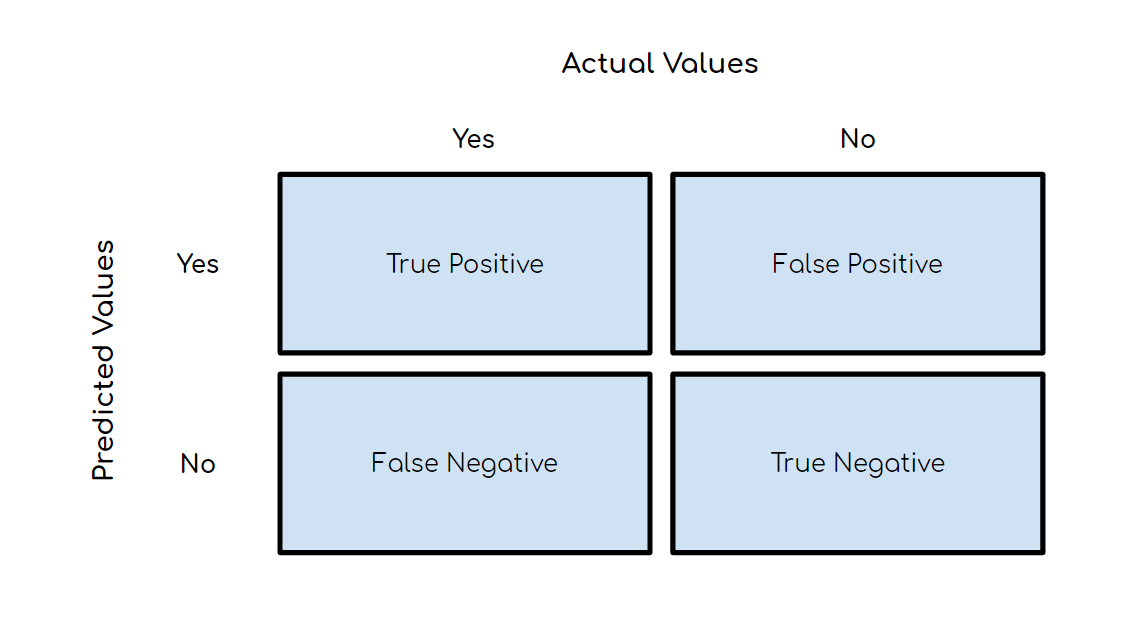
Figura 1. Matriz de confusión.  (Gomila, J. G, 2023) 

Con la Fig 1. es como funciona una matriz de confuión. De lo cual el siguiente análisis se pudo apreciar lo siguiente en los resultados obtenidos: 

1. En la `probabilidad 0.0` se ignoro los casos positivo y este logro obtener un F1 de **0** 
2. En la `probabilidad 0.11` se puede apreciar que comenzo a capturar algunos positivos y el F1 comienza a mejorar debidó a que este se logró el `0.12
3. En la `probabilidad 0.50`se puede observar que casi se logra un equilibrio en los valores verdaderos positivos y falsos positivos, aunque se obtuvo un F1 de `0.20`este sigue siendo bajo pero moderado. 
4. Por ultimo, la `probabilidad de 1` Este modelo predice siempre 1, resultando en un F1 similar al modelo con probabilidad 0.50. Aunque clasifica correctamente a los clientes que reciben una prestación, comete muchos errores en los casos negativos. 

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [26]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y) 
        
    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [27]:
def eval_regressor(y_true, y_pred):
    
    rmse = (sklearn.metrics.mean_squared_error(y_true, y_pred)) ** 0.5
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = (sklearn.metrics.r2_score(y_true, y_pred)) ** 0.5
    print(f'R2: {r2_score:.2f}')    

In [28]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


Con los valores obtenidos se puede llenar a la siguiente conclusión: 
1. El primer valor que se obtuvo de la matriz se puede conmsiderar como el intercepto. En este se llego a un valor de `-0.944` y este es el valor medio de `insurance_benefits`, 
2. En el coficiente de `age`se logró obtener un valor de `0.00357`. Dicho valor esta asociado con un aumento de ese valor en `insurance_benefits`en el caso de las que las variables se mantienen constante. 
3. En el coficiente de `gender` se logró un valor de `0.0164`. Esto nos indica que habrá cambios en la variable de `gender`con un aumento del valor que se obtuvo en `insurance_benefits` y asi manteniendo todas las constantes. 
4. En el caso de `income`se logró un valor de $-2.607^{-7}$ Lo que este sugiere que hay una poca relación entre ambas variables en el modelo. Esto se debe por que tiene un efecto minímo y negativo en `insurance_benefits`
5. En el caso de `family_members`se puede llegar a concluir de que un aumento aquí este afectara y disminuye en `insurance_benefits`en 0.0117 
6. En el valor del `RMSE` Las predicciones del modelo se desvían del valor real en alrededor de 0.34 unidades de insurance_benefits.
7. En el $R^{2}$ Esta métrica sugiere que el modelo explica el 66% de la variabilidad de insurance_benefits en los datos.

Con esto se puede llegar a concluir de que el modelo una buena parte de la relación entre las características y insurance_benefits, pero hay margen para mejorar el ajuste y la capacidad explicativa del modelo.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [29]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [30]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [31]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [32]:
 determinant = np.linalg.det(P)

if  determinant !=0: 
    print("La matriz P es invertible")
else: 
    print("La mtriz P no es invertible")

print("El determinante de P:",  determinant)

La matriz P es invertible
El determinante de P: 0.24339135998015463


Con el valor del determinante se puede observar que nuestra matriz si es posible invertir debido al valor que se obtuvo. 

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

Con esto no sería posble deducir con el modelo ya que los valores originales de las  características tales como la edad o ingresos en X' debido a que esto e están “mezclados” por combinaciones lineales que ocultan la relación directa con cada característica.

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [33]:
X_dot = np.dot(X, P)

# Recuperar los datos originales usando la inversa de P
P_inv = np.linalg.inv(P)  #
X_reco = np.dot(X_dot, P_inv )

#Mostrar los 3 casos 
print("Datos originales X:\n", X[:3])          # Primeros 3 clientes
print("Datos recuperados X_recovered:\n", X_reco[:3]) # Primeros 3 clientes recuperados
print("Datos transformados X':\n", X_dot[:3]) # Primeros 3 clientes transformados

Datos originales X:
 [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]]
Datos recuperados X_recovered:
 [[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]]
Datos transformados X':
 [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]]


Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Tal vez la razón  por la que hay un poco de diferencias de los datos originales y los que se recuperaron se ha por el redondeo. 

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

**1. La relación de  $w$ y $w_P$:**

Se sabe que $X_P$ = $X \times P$, en donde $P$ es una matriz transformada. Se podría reescribir $w_P$ de la siguiente manera:

$$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Ahora se expandera los términos: 

$$
(X P) ^ {T} (X P) = P^{T} X^{T} XP
$$

$$
(X P) ^ {T} y =   P^{T} X^{T} y
$$

Sabiendo esto, se prosigue a sustituir los valor en $w_P$ y la formula quedaría de la siguiente forma:
$$
w_P = (P^{T} X^{T} XP)^{-1} (P^{T} X^{T} y)
$$

Para poder simplicar más la formula, se utilizara el Ápendice B en el cual viene detallado las propiedades de las matirces y se utilizara este $(AB)^{-1} = B^{-1}A^{-1}$ si en el caso de ($A$ y $B$ son invertibles): 

$$
w_P = P^{-1}(X^{T} X)^{-1} (P^{T})^{-1} (P^{T} X^{T} y)
$$

Sabiendo esto se puede simplificar debido a que la siguiente formula: 
$$
w = (X^T X)^{-1} X^T
$$

Sabiendo eso, nuestra formula quedaría de la siguiente forma
$$
w_P = P^{-1}(X^{T} X)^{-1}  X^{T} y \quad \Rightarrow \quad w_P = P^{-1} w
$$

Por ende, los coeficientes ajustados con los datos transformados $XP$ están relacionados con los originales por la transformación de $P^{-1}$

**2. Valores predichos con $w_P$**

Se utilizara la siguiente fórmula:
$$
\hat{y}_P = (XP)w_P
$$

Dicha fórmula representa los valores predichos en un modelo de regresión lineal cuando los datos originales $X$ han sido transformados mediante una matriz $P$.

Sabiendo la fórmula de $w_p$, este se sustituira en la fórmula y quedaría de la siguiente manera: 
$$
\hat{y}_P = (XP)P^{-1} w \quad \Rightarrow \quad \hat{y}_P = X(P P^{-1}) w
$$
Dando como resultado la siguiente fórmula 
$$
\hat{y}_P = Xw
$$ 

Con esto podemos concluir que los valores predichos por $\hat{y}_P$ son exactamente iguales a los valores predichos a los valores originales  $$\hat{y}_P = Xw$$ . La transoformada de $P$ no afecta la predicción. 

**3. Calidad de la regresión medida mediante la RECM**

La raíz del error cuadriatico medio, o también conocida como RECM, se calcula mediante la siguiente formula: 

$$
RECM = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^{2}}
$$

Dado que los valores predichos por $\hat{y}_P$ son iguales a $\hat{y}$, el RECM no se ve afecto y este no cambia. Por ende, la calidad de la regresión líneal, medida mediante el RECM. No se vera afecto por la transformación de $P$ 

En conclusión:
1. $w_P$ está relacionado con $w$ mediante  $w_P = P^{-1} w$
2. Los valores predichos no cambian, $\hat{y}_P = \hat{y}$ 
3. La calidad de la regresión (medida por RECM) permanece igual, ya que las predicciones son invariantes bajo la transformación.

**Prueba analítica**

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [38]:
# Paso 1: Generar la matriz de ofuscación P
import numpy as np
from numpy.linalg import det, inv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# 1. Generación de datos de ejemplo: 

np.random.seed(40)
#Con la np.random.rad() se haran Valores aleatorios en una forma determinada.
#https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html 
X = np.random.rand(100,4) # Matriz de características en donde habrá 100 muestras y 4 características 
y = np.random.rand(100) #Valor objetivo 

#2. Creación de matriz cuadrada aleatoria de P y aswgurarse de que este invertible. 
def generate_invert_matrix(size, seed = 42):
    rng = np.random.default_rng(seed=42)
    P = rng.random(size=(size, size))
    while det(P) == 0:
        P = rng.random(size=(size, size))
    return P
    
P = generate_invert_matrix(X.shape[1])
print("Matriz P es invertible. Determinante:", det(P))


Matriz P es invertible. Determinante: 0.24339135998015463


In [39]:
# Paso 2: Creación de clase para ejecutar la regresión lineal con y sin ofuscación
class LinearRegressionWithObfuscation:
    def __init__(self, X, y, P):
        self.X = X  # Datos originales
        self.y = y
        self.P = P  # Matriz de ofuscación
        self.model_original = LinearRegression()
        self.model_obfuscated = LinearRegression()

    def fit_and_evaluate(self):
        # Ajuste en los datos originales
        self.model_original.fit(self.X, self.y)
        y_pred_original = self.model_original.predict(self.X)
        rmse_original = mean_squared_error(self.y, y_pred_original, squared=False)
        r2_original = r2_score(self.y, y_pred_original)

        # Ajuste en los datos ofuscados
        X_obfuscated = self.X @ self.P  # Transformar X usando la matriz de ofuscación P
        self.model_obfuscated.fit(X_obfuscated, self.y)
        y_pred_obfuscated = self.model_obfuscated.predict(X_obfuscated)
        rmse_obfuscated = mean_squared_error(self.y, y_pred_obfuscated, squared=False)
        r2_obfuscated = r2_score(self.y, y_pred_obfuscated)

        # Resultados
        results = {
            "Original": {"RMSE": rmse_original, "R2": r2_original},
            "Obfuscated": {"RMSE": rmse_obfuscated, "R2": r2_obfuscated},
        }
        return results, y_pred_original, y_pred_obfuscated

# Crear una instancia de la clase y evaluar
regression_test = LinearRegressionWithObfuscation(X, y, P)
results, y_pred_original, y_pred_obfuscated = regression_test.fit_and_evaluate()

print("Resultados:")
print("Datos originales:", results["Original"])
print("Datos ofuscados:", results["Obfuscated"])

Resultados:
Datos originales: {'RMSE': 0.2950992437858726, 'R2': 0.025344619445486827}
Datos ofuscados: {'RMSE': 0.29509924378587254, 'R2': 0.02534461944548705}


# Conclusiones

Como se pudo observar es que loos valores de RMSE son casi idénticos en tanto en los datos originales y en los ofuscados, lo que demuestra que la ofuscación de datos no afecta la precisión de las predicciones. El modelo ajustado a los datos ofuscados produce predicciones de la misma calidad que el modelo ajustado a los datos originales.

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>

**REFERENCIAS** 

Gomila, J. G. (2023, Marzo 08). Matriz de confusión en Machine Learning. Frogames. https://cursos.frogamesformacion.com/pages/blog/matriz-de-confusion